In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# ============================================================
# NOTEBOOK 5: MÉTRICAS, MONTE CARLO Y ANÁLISIS CRÍTICO
# ============================================================



# ------------------------------------------------------------
# 1. CARGA DE DATOS
# ------------------------------------------------------------
portfolio_daily = pd.read_parquet("resources/portfolio_daily.parquet")

# Descargamos SPY como benchmark
spy = yf.download("SPY", start="2015-01-30", end="2026-01-31", auto_adjust=True)
spy.columns = spy.columns.droplevel(1)  # eliminamos el nivel extra
spy = spy[['Close']].rename(columns={'Close': 'spy_close'})
spy.index.name = 'date'
spy = spy.reset_index()


print(f"Portfolio días: {len(portfolio_daily)}")
print(f"SPY días: {len(spy)}")
spy.head()

[*********************100%***********************]  1 of 1 completed

Portfolio días: 2767
SPY días: 2767


Price,date,spy_close
0,2015-01-30,165.623840
1,2015-02-02,167.674881
2,2015-02-03,170.099686
3,2015-02-04,169.451981
4,2015-02-05,171.162598


In [3]:
# ------------------------------------------------------------
# 2. FUSIÓN Y RETORNOS
# ------------------------------------------------------------

# Fusionamos por fecha
df = portfolio_daily.merge(spy, on='date', how='inner')

# Retornos diarios logarítmicos
df['ret_portfolio'] = np.log(df['portfolio_value'] / df['portfolio_value'].shift(1))
df['ret_spy'] = np.log(df['spy_close'] / df['spy_close'].shift(1))

# Retornos mensuales (para histograma y scatter)
df['year_month'] = df['date'].dt.to_period('M')
monthly = df.groupby('year_month').agg(
    portfolio_value=('portfolio_value', 'last'),
    spy_close=('spy_close', 'last')
).reset_index()

monthly['ret_portfolio'] = np.log(monthly['portfolio_value'] / monthly['portfolio_value'].shift(1))
monthly['ret_spy'] = np.log(monthly['spy_close'] / monthly['spy_close'].shift(1))
monthly = monthly.dropna()

print(f"Días con retornos: {df['ret_portfolio'].dropna().shape[0]}")
print(f"Meses con retornos: {len(monthly)}")
df.head()

Días con retornos: 2766
Meses con retornos: 132


,date,portfolio_value,return_pct,spy_close,ret_portfolio,ret_spy,year_month
0,2015-01-30,249454.953125,-0.218016,165.623840,NaN,NaN,2015-01
1,2015-02-02,249930.906250,-0.027639,167.674881,0.001906,0.012308,2015-02
2,2015-02-03,251893.375000,0.757349,170.099686,0.007821,0.014358,2015-02
3,2015-02-04,252049.312500,0.819731,169.451981,0.000619,-0.003815,2015-02
4,2015-02-05,254808.000000,1.923203,171.162598,0.010886,0.010044,2015-02


In [4]:
# ------------------------------------------------------------
# 3. MÉTRICAS
# ------------------------------------------------------------

def calculate_metrics(returns, benchmark_returns, portfolio_values, rf=0.0):
    """
    Calcula CAGR, Volatilidad, Sharpe, Sortino, Max Drawdown, Beta y Alpha.
    rf: tasa libre de riesgo anual (asumimos 0 para simplificar)
    """
    n_days = len(returns)
    n_years = n_days / 252

    # CAGR
    total_return = portfolio_values.iloc[-1] / portfolio_values.iloc[0]
    cagr = total_return ** (1 / n_years) - 1

    # Volatilidad anualizada
    vol = returns.std() * np.sqrt(252)

    # Sharpe
    sharpe = (returns.mean() * 252 - rf) / vol

    # Sortino (solo volatilidad de retornos negativos)
    downside = returns[returns < 0].std() * np.sqrt(252)
    sortino = (returns.mean() * 252 - rf) / downside

    # Máximo Drawdown
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    max_dd = drawdown.min()

    # Beta y Alpha
    cov_matrix = np.cov(returns.dropna(), benchmark_returns.dropna())
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    alpha = (returns.mean() - beta * benchmark_returns.mean()) * 252

    return {
        'CAGR': f"{cagr:.2%}",
        'Volatilidad': f"{vol:.2%}",
        'Sharpe': f"{sharpe:.2f}",
        'Sortino': f"{sortino:.2f}",
        'Max Drawdown': f"{max_dd:.2%}",
        'Beta': f"{beta:.2f}",
        'Alpha': f"{alpha:.2%}"
    }

# Eliminamos el primer NaN
rets = df['ret_portfolio'].dropna()
rets_spy = df['ret_spy'].dropna()

metrics_portfolio = calculate_metrics(rets, rets_spy, df['portfolio_value'])
metrics_spy = calculate_metrics(rets_spy, rets_spy, df['spy_close'])

# Tabla comparativa
metrics_df = pd.DataFrame([metrics_portfolio, metrics_spy],
                           index=['Momentum Strategy', 'SPY'])
print(metrics_df.T)

             Momentum Strategy      SPY
CAGR                    17.37%   13.91%
Volatilidad             27.36%   17.79%
Sharpe                    0.59     0.73
Sortino                   0.72     0.87
Max Drawdown           -44.09%  -35.75%
Beta                      1.13     1.00
Alpha                    1.24%    0.00%


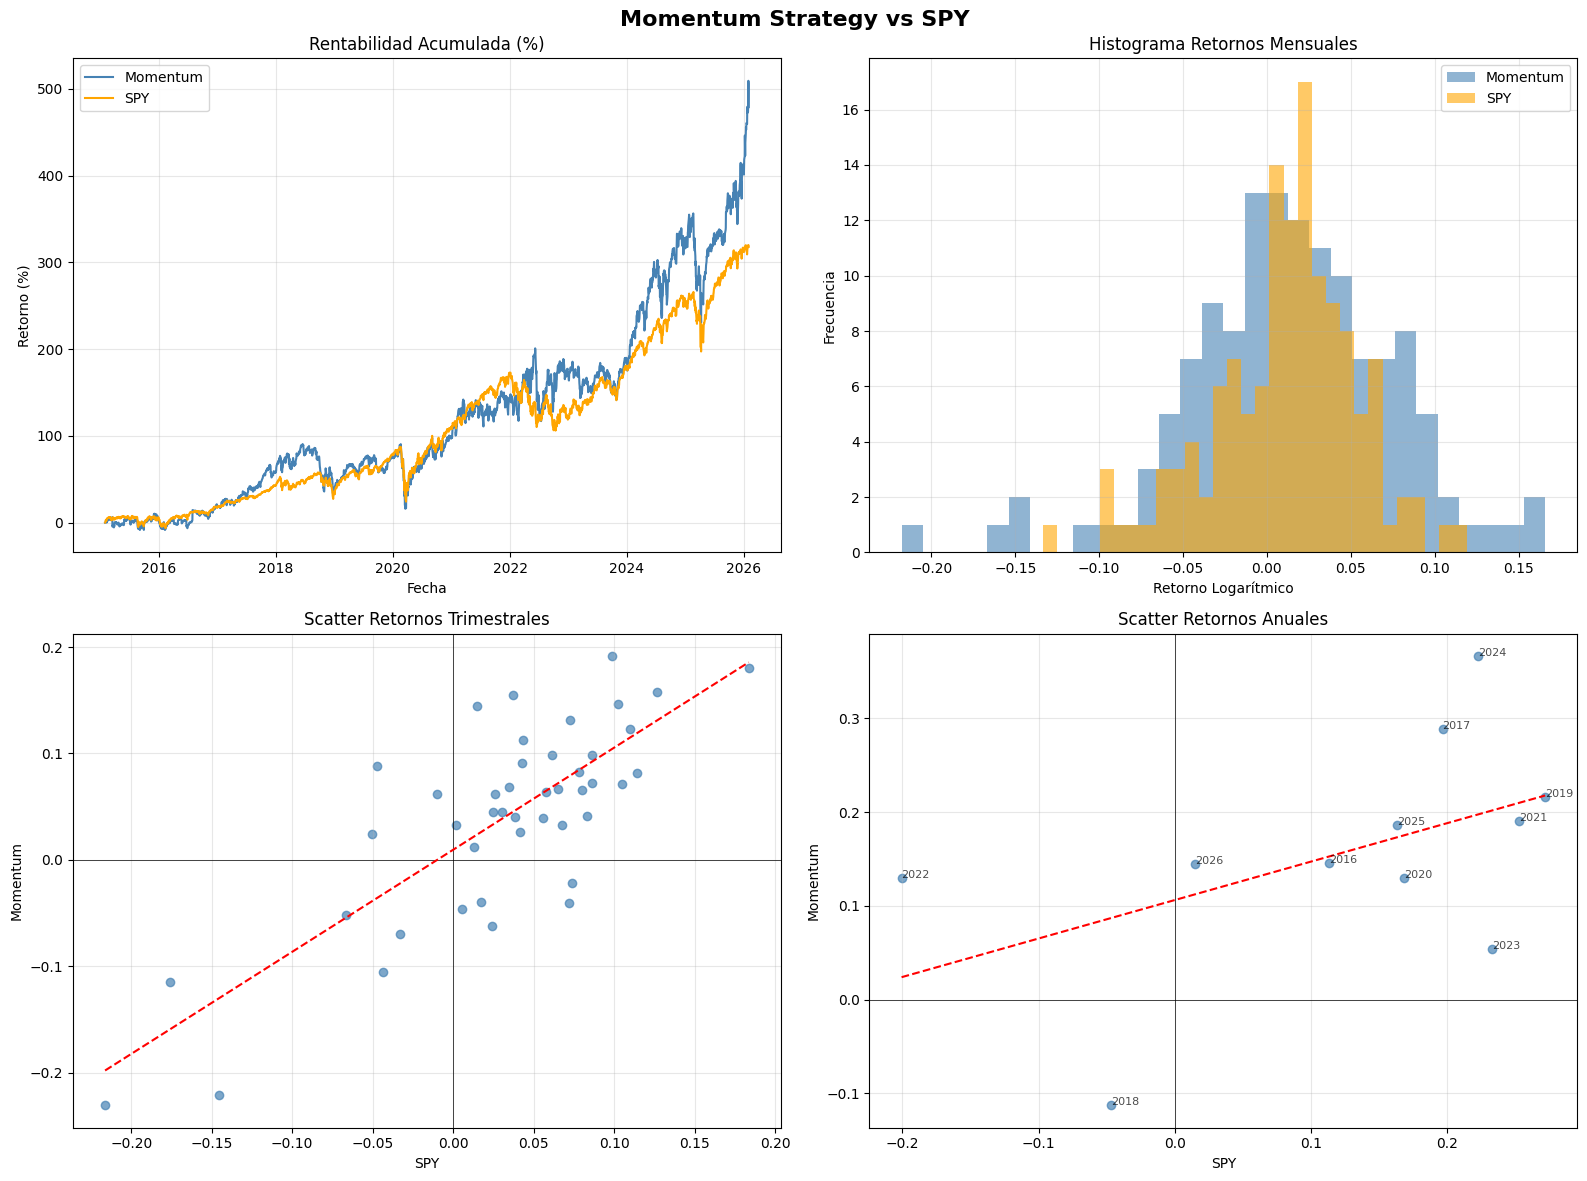

✅ Gráficos guardados


In [5]:
# ------------------------------------------------------------
# 4. VISUALIZACIONES
# ------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Momentum Strategy vs SPY', fontsize=16, fontweight='bold')

# -- GRÁFICO 1: Rentabilidad acumulada --
ax1 = axes[0, 0]
ax1.plot(df['date'], df['return_pct'], label='Momentum', color='steelblue')
spy_return_pct = (df['spy_close'] / df['spy_close'].iloc[0] - 1) * 100
ax1.plot(df['date'], spy_return_pct, label='SPY', color='orange')
ax1.set_title('Rentabilidad Acumulada (%)')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Retorno (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# -- GRÁFICO 2: Histograma retornos mensuales --
ax2 = axes[0, 1]
ax2.hist(monthly['ret_portfolio'].dropna(), bins=30, alpha=0.6,
         label='Momentum', color='steelblue')
ax2.hist(monthly['ret_spy'].dropna(), bins=30, alpha=0.6,
         label='SPY', color='orange')
ax2.set_title('Histograma Retornos Mensuales')
ax2.set_xlabel('Retorno Logarítmico')
ax2.set_ylabel('Frecuencia')
ax2.legend()
ax2.grid(True, alpha=0.3)

# -- GRÁFICO 3: Scatter rentabilidades trimestrales --
df['quarter'] = df['date'].dt.to_period('Q')
quarterly = df.groupby('quarter').agg(
    portfolio_value=('portfolio_value', 'last'),
    spy_close=('spy_close', 'last')
).reset_index()
quarterly['ret_portfolio'] = np.log(quarterly['portfolio_value'] / quarterly['portfolio_value'].shift(1))
quarterly['ret_spy'] = np.log(quarterly['spy_close'] / quarterly['spy_close'].shift(1))
quarterly = quarterly.dropna()

ax3 = axes[1, 0]
ax3.scatter(quarterly['ret_spy'], quarterly['ret_portfolio'],
            alpha=0.7, color='steelblue')
ax3.axhline(0, color='black', linewidth=0.5)
ax3.axvline(0, color='black', linewidth=0.5)
# Línea de regresión
m, b = np.polyfit(quarterly['ret_spy'], quarterly['ret_portfolio'], 1)
x_line = np.linspace(quarterly['ret_spy'].min(), quarterly['ret_spy'].max(), 100)
ax3.plot(x_line, m * x_line + b, color='red', linewidth=1.5, linestyle='--')
ax3.set_title('Scatter Retornos Trimestrales')
ax3.set_xlabel('SPY')
ax3.set_ylabel('Momentum')
ax3.grid(True, alpha=0.3)

# -- GRÁFICO 4: Scatter rentabilidades anuales --
df['year'] = df['date'].dt.to_period('Y')
yearly = df.groupby('year').agg(
    portfolio_value=('portfolio_value', 'last'),
    spy_close=('spy_close', 'last')
).reset_index()
yearly['ret_portfolio'] = np.log(yearly['portfolio_value'] / yearly['portfolio_value'].shift(1))
yearly['ret_spy'] = np.log(yearly['spy_close'] / yearly['spy_close'].shift(1))
yearly = yearly.dropna()

ax4 = axes[1, 1]
ax4.scatter(yearly['ret_spy'], yearly['ret_portfolio'],
            alpha=0.7, color='steelblue')
for _, row in yearly.iterrows():
    ax4.annotate(str(row['year']),
                (row['ret_spy'], row['ret_portfolio']),
                fontsize=8, alpha=0.7)
ax4.axhline(0, color='black', linewidth=0.5)
ax4.axvline(0, color='black', linewidth=0.5)
m, b = np.polyfit(yearly['ret_spy'], yearly['ret_portfolio'], 1)
x_line = np.linspace(yearly['ret_spy'].min(), yearly['ret_spy'].max(), 100)
ax4.plot(x_line, m * x_line + b, color='red', linewidth=1.5, linestyle='--')
ax4.set_title('Scatter Retornos Anuales')
ax4.set_xlabel('SPY')
ax4.set_ylabel('Momentum')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resources/visualizaciones.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Gráficos guardados")

In [6]:
# ------------------------------------------------------------
# 5. MONTE CARLO — 25 MILLONES DE MONOS
# ------------------------------------------------------------
import time

N_MONOS = 25_000_000
COMMISSION_MONKEY = 0.0023 * 2  # 0.46% compra + venta
N_ASSETS = 20
INITIAL_CAPITAL = 250_000

# Necesitamos los retornos mensuales del universo elegible
# Para cada fecha de rebalanceo, los retornos del mes siguiente
# (lo que gana el mono tras seleccionar)

eligible_universe = pd.read_parquet("resources/eligible_universe.parquet")
monthly_closes = pd.read_parquet("resources/monthly_closes.parquet")
rebalancing_dates = pd.read_parquet("resources/rebalancing_dates.parquet")

# Para cada fecha de rebalanceo, calculamos el retorno del mes siguiente
# de cada activo elegible
rebal_dates = rebalancing_dates['date'].tolist()

# Matriz de retornos: filas=fechas rebalanceo, columnas=activos
# Para cada fecha, cogemos los activos elegibles y su retorno en el mes siguiente
monthly_closes['period'] = monthly_closes['date'].dt.to_period('M')

period_to_date = (monthly_closes.groupby('period')['date']
                  .max()
                  .to_dict())

monkey_returns = []  # lista de arrays, uno por fecha de rebalanceo

for rebal_date in rebal_dates[:-1]:  # excluimos el último (no hay mes siguiente)
    # Mes siguiente al rebalanceo
    next_period = (rebal_date + pd.DateOffset(months=1)).to_period('M')

    # Activos elegibles en esta fecha
    eligible = eligible_universe[
        eligible_universe['rebal_date'] == rebal_date
    ]['symbol'].tolist()

    # Retorno del mes siguiente para cada activo elegible
    next_date = period_to_date.get(next_period)
    if next_date is None:
        continue

    rets = monthly_closes[
        (monthly_closes['date'] == next_date) &
        (monthly_closes['symbol'].isin(eligible))
    ].set_index('symbol')['log_return'].dropna()

    if len(rets) >= N_ASSETS:
        monkey_returns.append(rets.values)

print(f"Periodos disponibles: {len(monkey_returns)}")
print(f"Media activos por periodo: {np.mean([len(r) for r in monkey_returns]):.0f}")

Periodos disponibles: 132
Media activos por periodo: 483


In [7]:
start_time = time.time()

np.random.seed(42)
BATCH_SIZE = 1_000_000
n_batches = N_MONOS // BATCH_SIZE
cagr_monos = np.zeros(N_MONOS)

for i in range(n_batches):
    # Para cada periodo, generamos índices aleatorios y cogemos retornos
    # Procesamos periodo a periodo — más eficiente en memoria
    batch_returns = np.zeros((BATCH_SIZE, n_periods))

    for t, rets in enumerate(monkey_returns):
        n = len(rets)
        # Seleccionamos 20 índices aleatorios para este periodo
        idx = np.random.randint(0, n, size=(BATCH_SIZE, N_ASSETS))
        batch_returns[:, t] = rets[idx].mean(axis=1)

    # Aplicamos coste y calculamos CAGR
    batch_returns -= COMMISSION_MONKEY
    total_return = np.exp(batch_returns.sum(axis=1))
    n_years = n_periods / 12
    cagr_monos[i * BATCH_SIZE:(i + 1) * BATCH_SIZE] = total_return ** (1 / n_years) - 1

    if i % 5 == 0:
        elapsed = time.time() - start_time
        print(f"Batch {i+1}/{n_batches} — {elapsed:.1f}s")

elapsed = time.time() - start_time
print(f"\n⏱️ Tiempo total: {elapsed:.1f} segundos")

NameError: name 'n_periods' is not defined

In [ ]:
# ------------------------------------------------------------
# VALIDACIÓN MONTE CARLO
# ------------------------------------------------------------

our_cagr = 0.1737

# Estadísticas de los monos
print(f"Resultados Monte Carlo ({N_MONOS:,} simulaciones)")
print(f"{'─'*45}")
print(f"CAGR medio monos:     {cagr_monos.mean():.2%}")
print(f"CAGR mediano monos:   {np.median(cagr_monos):.2%}")
print(f"CAGR std monos:       {cagr_monos.std():.2%}")
print(f"CAGR mín monos:       {cagr_monos.min():.2%}")
print(f"CAGR máx monos:       {cagr_monos.max():.2%}")
print(f"{'─'*45}")
print(f"Nuestro CAGR:         {our_cagr:.2%}")
percentile = (cagr_monos < our_cagr).mean() * 100
print(f"Percentil:            {percentile:.1f}%")
print(f"Superamos a:          {percentile:.1f}% de los monos")

# Gráfico
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(cagr_monos, bins=100, color='steelblue', alpha=0.7, label='Monos aleatorios')
ax.axvline(our_cagr, color='red', linewidth=2, linestyle='--', label=f'Nuestra estrategia ({our_cagr:.1%})')
ax.axvline(np.median(cagr_monos), color='orange', linewidth=2, linestyle='--', label=f'Mediana monos ({np.median(cagr_monos):.1%})')
ax.set_title('Monte Carlo — Distribución CAGR de 25 millones de carteras aleatorias')
ax.set_xlabel('CAGR')
ax.set_ylabel('Frecuencia')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resources/monte_carlo.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
print(f"Media retornos monkey_matrix: {monkey_matrix.mean():.4f}")
print(f"Comisión mensual aplicada: {COMMISSION_MONKEY:.4f}")
print(f"CAGR medio monos: {cagr_monos.mean():.4f}")
print(f"Retorno mensual medio portfolio real: {monthly['ret_portfolio'].mean():.4f}")
print(f"Retorno mensual medio SPY: {monthly['ret_spy'].mean():.4f}")

In [ ]:
# La comisión del 0.46% se aplica sobre el capital, no como retorno log
# Factor de coste mensual: (1 - 0.0046)
COST_FACTOR = np.log(1 - COMMISSION_MONKEY)  # convertimos a log return
print(f"Coste mensual en log returns: {COST_FACTOR:.6f}")
print(f"Coste que estábamos aplicando: {COMMISSION_MONKEY:.6f}")

In [ ]:
# Verificamos que los retornos del universo son razonables
print(f"% retornos negativos en monkey_matrix: {(monkey_matrix < 0).mean():.2%}")
print(f"% retornos > 0.20 (outliers): {(monkey_matrix > 0.20).mean():.2%}")
print(f"% retornos < -0.20 (outliers): {(monkey_matrix < -0.20).mean():.2%}")
print(f"Mediana retornos monkey_matrix: {np.median(monkey_matrix):.4f}")